# CS 484 Final Project

Plan:
1. read some more papers and find all the datasets
  a) we can use resnet50 as encoder, and then I think we build a more complicated decoder
2. try to see if we can get an overfitted model to work
3. try to see if we can extend that model
4. Great Success


## Abstract

TODO

## Data Synthesis

In [38]:
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries.
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision.models as models


In [ ]:
# !pip install pytorch-ignite


   ---------------------------------------- 0.0/343.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/343.2 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 343.2/343.2 kB 4.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from ignite.metrics import SSIM
# pytorch ignite can be installed using pip as show above or by following any of the instructions at https://pytorch-ignite.ai/how-to-guides/01-installation/

## Model

In [ ]:
### model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)


## Reconstructing the image from the disparity

In [72]:
import tensorflow

def bilinear_sampler_1d_h(input_images, x_offset, wrap_mode='border', name='bilinear_sampler', **kwargs):
    def _repeat(x, n_repeats):
        with tensorflow.compat.v1.variable_scope('_repeat'):
            rep = tensorflow.tile(tensorflow.expand_dims(x, 1), [1, n_repeats])
            return tensorflow.reshape(rep, [-1])

    def _interpolate(im, x, y):
        with tensorflow.compat.v1.variable_scope('_interpolate'):

            # handle both texture border types
            _edge_size = 0
            if _wrap_mode == 'border':
                _edge_size = 1
                im = tensorflow.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
                x = x + _edge_size
                y = y + _edge_size
            elif _wrap_mode == 'edge':
                _edge_size = 0
            else:
                return None

            x = tensorflow.clip_by_value(x, 0.0,  _width_f - 1 + 2 * _edge_size)

            x0_f = tensorflow.floor(x)
            y0_f = tensorflow.floor(y)
            x1_f = x0_f + 1

            x0 = tensorflow.cast(x0_f, tensorflow.int32)
            y0 = tensorflow.cast(y0_f, tensorflow.int32)
            x1 = tensorflow.cast(tensorflow.minimum(x1_f,  _width_f - 1 + 2 * _edge_size), tensorflow.int32)

            dim2 = (_width + 2 * _edge_size)
            dim1 = (_width + 2 * _edge_size) * (_height + 2 * _edge_size)
            base = _repeat(tensorflow.range(_num_batch) * dim1, _height * _width)
            base_y0 = base + y0 * dim2
            idx_l = base_y0 + x0
            idx_r = base_y0 + x1

            im_flat = tensorflow.reshape(im, tensorflow.stack([-1, _num_channels]))

            pix_l = tensorflow.gather(im_flat, idx_l)
            pix_r = tensorflow.gather(im_flat, idx_r)

            weight_l = tensorflow.expand_dims(x1_f - x, 1)
            weight_r = tensorflow.expand_dims(x - x0_f, 1)

            return weight_l * pix_l + weight_r * pix_r

    def _transform(input_images, x_offset):
        with tensorflow.compat.v1.variable_scope('transform'):
            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            x_t, y_t = tensorflow.meshgrid(tensorflow.linspace(0.0,   _width_f - 1.0,  _width),
                                   tensorflow.linspace(0.0 , _height_f - 1.0 , _height))

            x_t_flat = tensorflow.reshape(x_t, (1, -1))
            y_t_flat = tensorflow.reshape(y_t, (1, -1))

            x_t_flat = tensorflow.tile(x_t_flat, tensorflow.stack([_num_batch, 1]))
            y_t_flat = tensorflow.tile(y_t_flat, tensorflow.stack([_num_batch, 1]))

            x_t_flat = tensorflow.reshape(x_t_flat, [-1])
            y_t_flat = tensorflow.reshape(y_t_flat, [-1])

            x_t_flat = x_t_flat + tensorflow.reshape(x_offset, [-1]) * _width_f

            input_transformed = _interpolate(input_images, x_t_flat, y_t_flat)

            output = tensorflow.reshape(
                input_transformed, tensorflow.stack([_num_batch, _height, _width, _num_channels]))
            return output

    with tensorflow.compat.v1.variable_scope(name):
        _num_batch    = tensorflow.shape(input_images)[0]
        _height       = tensorflow.shape(input_images)[1]
        _width        = tensorflow.shape(input_images)[2]
        _num_channels = tensorflow.shape(input_images)[3]

        _height_f = tensorflow.cast(_height, tensorflow.float32)
        _width_f  = tensorflow.cast(_width,  tensorflow.float32)

        _wrap_mode = wrap_mode

        output = _transform(input_images, x_offset)
        return output


def generate_image_left(img, disp):
    return bilinear_sampler_1d_h(img, -disp)

def generate_image_right(img, disp):
    return bilinear_sampler_1d_h(img, disp)


In [ ]:
import torch
import torch.nn.functional as F

def bilinear_sampler_1d_h(img, disp, wrap_mode='border'):
    """
    Args:
        img: (B, C, H, W) input image (e.g. left image)
        disp: (B, 1, H, W) disparity map (e.g. right disparity, applied to the left image)
        wrap_mode: 'border' or 'edge' padding

    Returns:
        Warped image: (B, C, H, W)
    """

    B, C, H, W = img.shape

    # Normalize disparity to [-1, 1]
    # Because grid_sample expects coords in [-1, 1]
    # We normalize by dividing by (W - 1) and scale to [-1, 1]
    # Disparity is subtracted because we're doing backward warping
    x_base = torch.linspace(-1.0, 1.0, W, device=img.device).view(1, 1, 1, W).expand(B, -1, H, -1)
    y_base = torch.linspace(-1.0, 1.0, H, device=img.device).view(1, 1, H, 1).expand(B, -1, -1, W)

    # Convert disparity from pixels to normalized coords
    disp_norm = disp / ((W - 1.0) / 2.0)  # scale to [-1, 1]
    x_shifted = x_base - disp_norm  # Subtract because we're sampling from the source

    # Combine x and y into grid
    grid = torch.cat((x_shifted, y_base), dim=1)  # shape (B, 2, H, W)
    grid = grid.permute(0, 2, 3, 1)  # shape (B, H, W, 2)

    # Bilinear sampling
    return F.grid_sample(img, grid, mode='bilinear', padding_mode=wrap_mode, align_corners=True)


## leftIm defines if we are reconstructing the left image or the right image
def reconStruct(im, disp, leftIm):
    if(leftIm):
        return bilinear_sampler_1d_h(im ,disp)
    else:
        return bilinear_sampler_1d_h(im, -1*disp)


Example on a ground truth image

torch.Size([3, 288, 384])


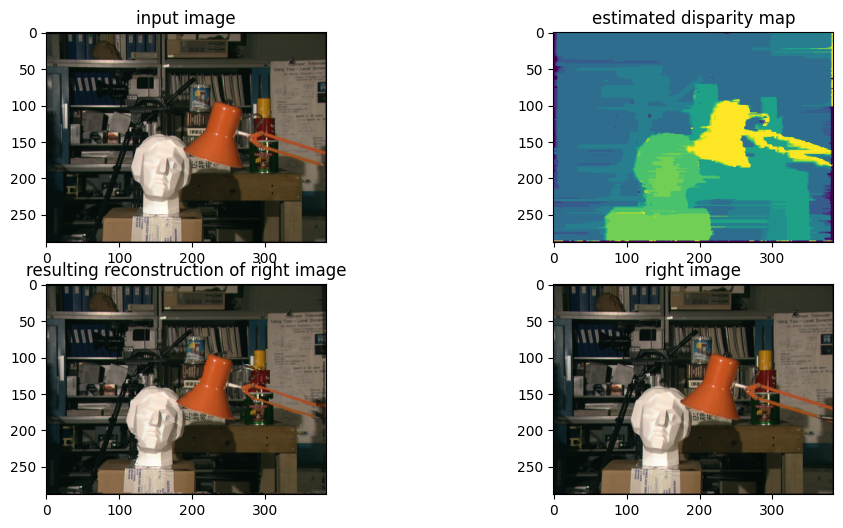

In [80]:
imL = Image.open("images/tsukuba/scene1.row3.col3.ppm")
# imL = Image.open("Backpack-perfect/im0.png")
gt = Image.open("images/tsukuba/truedisp.row3.col3.pgm")
# gt = Image.open("Backpack-perfect/disp0.pfm")
gt = np.load("images/tsukuba/resMap.pgm")
gt = np.astype(gt, np.float32)
gt = tF.to_tensor(gt)

# gt[gt==float("inf")] = 0
# gt = gt
# gt = tF.to_pil_image(gt)


imR = Image.open("images/tsukuba/scene1.row3.col4.ppm")
# imR = Image.open("Backpack-perfect/im1.png")

# print(np.max(gt))
# print(torch.unique(tF.to_tensor(gt)))
# print()

print(tF.to_tensor(imL).shape)
# print(tF.to_tensor(gt).shape)
# print(generate_image_right(tF.to_tensor(im)[None], tF.to_tensor(gt)[None]).shape)
# regen_im = generate_image_right(tF.to_tensor(imL)[None], tF.to_tensor(gt)[None])[0]
regen_im = reconStruct(tF.to_tensor(imL)[None], gt[None], False)[0]
gt = gt.permute(1, 2, 0)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("input image")
ax1.imshow(imL)
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("estimated disparity map")
ax2.imshow(gt)
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("resulting reconstruction of right image")
ax3.imshow(regen_im.permute(1, 2, 0))
ax3 = fig.add_subplot(2, 2, 4)
ax3.set_title("right image")
ax3.imshow(imR)




## Loss Function

source of loss function:
from paper

Difficulties with loss function:
- keeping the loss function only with tensor operations to keep the .backward() functionality valid

In [ ]:

# from pytorch_ssim import SSIM 
from ignite.metrics import SSIM
import torch # delete this later


# def SSIM(self, x, y):
#     C1 = 0.01 ** 2
#     C2 = 0.03 ** 2

#     mu_x = slim.avg_pool2d(x, 3, 1, 'VALID')
#     mu_y = slim.avg_pool2d(y, 3, 1, 'VALID')

#     sigma_x  = slim.avg_pool2d(x ** 2, 3, 1, 'VALID') - mu_x ** 2
#     sigma_y  = slim.avg_pool2d(y ** 2, 3, 1, 'VALID') - mu_y ** 2
#     sigma_xy = slim.avg_pool2d(x * y , 3, 1, 'VALID') - mu_x * mu_y

#     SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
#     SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

#     SSIM = SSIM_n / SSIM_d

#     return tF.clip_by_value((1 - SSIM) / 2, 0, 1)

def ssim(img1, img2):
    """Simplified SSIM using a 3x3 filter."""
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, 3, 1, 1)
    mu2 = F.avg_pool2d(img2, 3, 1, 1)

    sigma1 = F.avg_pool2d(img1 * img1, 3, 1, 1) - mu1 ** 2
    sigma2 = F.avg_pool2d(img2 * img2, 3, 1, 1) - mu2 ** 2
    sigma12 = F.avg_pool2d(img1 * img2, 3, 1, 1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2))
    return torch.clamp((1 - ssim_map) / 2, 0, 1)

def gradient_x(img):
    return img[:, :, :, :-1] - img[:, :, :, 1:]

def gradient_y(img):
    return img[:, :, :-1, :] - img[:, :, 1:, :]


def appearance_loss(img, recon, alpha):
    l1 = torch.abs(img - recon)
    ssim_loss = ssim(img, recon) #(1 - SSIM)/2 built in already
    return (alpha * ssim_loss.mean()) + ((1 - alpha) * l1.mean())

def disparity_smoothness(disp, img):
    disp_grad_x = gradient_x(disp)
    disp_grad_x[torch.isinf(disp_grad_x)] = 0
    disp_grad_x[torch.isnan(disp_grad_x)] = 0
    disp_grad_y = gradient_y(disp)
    disp_grad_y[torch.isinf(disp_grad_y)] = 0
    disp_grad_y[torch.isnan(disp_grad_y)] = 0
    img_grad_x = gradient_x(img)
    img_grad_y = gradient_y(img)

    # print(img_grad_x.shape)
    
    weights_x = torch.exp(-torch.sum(torch.abs(img_grad_x), 1, keepdim=True))
    weights_y = torch.exp(-torch.sum(torch.abs(img_grad_y), 1, keepdim=True))

    smoothness_x = torch.abs(disp_grad_x * weights_x)
    smoothness_y = disp_grad_y * weights_y
    # print(torch.isnan(smoothness_x).any())
    return smoothness_x.abs().mean() + smoothness_y.abs().mean()



def lr_consistency_loss(disp_left, disp_right):
    """
    Args:
        disp_left:  [B, 1, H, W] disparity map from left view (predicts right image)
        disp_right: [B, 1, H, W] disparity map from right view (predicts left image)

    Returns:
        Scalar tensor representing left-right consistency loss.
    """

    # if it comes in as [1, H, W] instead
    # disp_left, disp_right = disp_left[None], disp_right[None]

    B, _, H, W = disp_left.shape

    # Create normalized horizontal coordinate grid
    grid_x = torch.linspace(-1.0, 1.0, W).view(1, 1, 1, W).expand(B, 1, H, W).to(disp_left.device)
    grid_y = torch.linspace(-1.0, 1.0, H).view(1, 1, H, 1).expand(B, 1, H, W).to(disp_left.device)

    # Normalize disparity to [-1, 1] range
    disp_left_norm = disp_left / ((W - 1) / 2)
    disp_right_norm = disp_right / ((W - 1) / 2)

    # Sample right disparity using left disparity to warp
    grid_warped_right = torch.cat([grid_x - disp_left_norm, grid_y], dim=1)
    grid_warped_right = grid_warped_right.permute(0, 2, 3, 1)  # [B, H, W, 2]
    sampled_right = F.grid_sample(disp_right, grid_warped_right, mode='bilinear', padding_mode='border', align_corners=True)

    # Sample left disparity using right disparity to warp
    grid_warped_left = torch.cat([grid_x + disp_right_norm, grid_y], dim=1)
    grid_warped_left = grid_warped_left.permute(0, 2, 3, 1)
    sampled_left = F.grid_sample(disp_left, grid_warped_left, mode='bilinear', padding_mode='border', align_corners=True)

    # L1 loss between disparity and its warped counterpart
    print(torch.isinf(disp_left).any())
    loss_left = torch.abs(disp_left - sampled_right).mean()
    loss_right = torch.abs(disp_right - sampled_left).mean()

    return loss_left + loss_right


def custom_loss(imL, imR, dL, dR, recImL, recImR, alpha=0.85, alpha_ap=1.0, alpha_ds=0.1, alpha_lr=1.0):

    loss_ap = appearance_loss(imL, recImL, alpha) + appearance_loss(imR, recImR, alpha)

    loss_ds = disparity_smoothness(dL, imL) + disparity_smoothness(dR, imR)

    loss_lr = lr_consistency_loss(dL, dR)
    if(torch.isnan(loss_lr)):
        # penalty to discourage infinite disparity
        loss_lr = 1000000000000
    # --- Total Loss ---
    total_loss = alpha_ap * loss_ap + alpha_ds * loss_ds + alpha_lr * loss_lr
    return total_loss



tensor([ 32.0820,  32.0876,  32.0931,  ..., 223.5396, 223.5399,      inf])
tensor(True)
tensor(0.3302) tensor(0.9265) 1000000000000
tensor(1.0000e+12)


Testing the loss function

In [130]:
imL =tF.to_tensor(Image.open("Backpack-perfect/im0.png"))[None]
imR =tF.to_tensor(Image.open("Backpack-perfect/im1.png"))[None]
dL = tF.to_tensor(Image.open("Backpack-perfect/disp0.pfm"))[None]
dL[torch.isinf(dL)] = 0
dR = tF.to_tensor(Image.open("Backpack-perfect/disp1.pfm"))[None]
dR[torch.isinf(dR)] = 0


print(custom_loss(imL, imR, dL, dR, reconStruct(imL, dL, False), reconStruct(imR, dR, True)))

tensor(False)
tensor(0.3179) tensor(9.5927) tensor(16.4083)
tensor(17.6855)


In [ ]:
# maybe add later
def disparity_image_loss(im, disp, lmbda = 1, sig = 1):
    """
    im: [3, H, W] image
    disp: [H, W] image
    """

## Validation

In [ ]:
# validate the output disparity map against the ground truth
def validateAgainstGroundTruthSingle(dl, gt):
    #idk how im going to do this yet, will need to figure out dimensions and shit
    return 0.5

def validateAgainstGroundTruth(val_loader, net):
    net = net.cuda()
    ttlDiff = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):

            imL, imR, gtDl, gtDr = data
            # if USE_GPU:
            imL, imR, gtDl, gtDr = imL.cuda(), imR.cuda(), gtDl.cuda(), gtDr.cuda()

            dL, dR = net.forward(imL)
            ttlDiff += validateAgainstGroundTruthSingle(dL, gtDl) + validateAgainstGroundTruthSingle(dR, gtDr)
    
    return ttlDiff/(2*len(val_loader))



def validate(val_loader, net, loss_function = custom_loss):

    net.eval()
    val_loss = 0

    # if USE_GPU:
    net = net.cuda()
    with torch.no_grad():
        for i, data in enumerate(val_loader):

            imL, imR, gtDl, gtDr = data
            # if USE_GPU:
            imL, imR, gtDl, gtDr = imL.cuda(), imR.cuda(), gtDl.cuda(), gtDr.cuda()


            dL, dR = net.forward(imL)
            val_loss += loss_function(imL, imR, dL, dR, reconStruct(imL, dR, True), reconStruct(imR, dL, False)).item()

    # return the values of loss and mIOU (averaged over the loaded data)
    return val_loss/len(val_loader.dataset)


## Trainer


In [ ]:
def train(train_loader, net, optimizer, loss_graph, loss_function = custom_loss):

    net.train()
    # if USE_GPU:
    net = net.cuda()
    val_loss = 0
    for i, data in enumerate(train_loader):

        imL, imR, gtDl, gtDr = data
        # if USE_GPU:
        imL, imR, gtDl, gtDr = imL.cuda(), imR.cuda(), gtDl.cuda(), gtDr.cuda()

        optimizer.zero_grad()
        dL, dR = net.forward(imL)
        main_loss = loss_function(imL, imR, dL, dR, reconStruct(imL, dR, False), reconStruct(imR, dL, True)).item()
        loss = main_loss.item()
        val_loss += loss
        loss_graph.append(loss)
        main_loss.backward()
        optimizer.step()
        # loss_graph.append() Populate this list to graph the loss

    # Return the value of loss (averaged over the loaded data)
    return val_loss/len(train_loader)

In [ ]:
def train_net(loader, net, optimizer, EPOCH):
    net.train()

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)

    for e in range(EPOCH):
        loss = train(loader, net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

## Overfit model
First, we are going to train an overfit net to a single image to get a sanity check that the error function and model are working as intended

In [ ]:
%%time

overfit_net = copy.deepcopy(untrained_net)

EPOCH = 40

optimizer = get_optimizer(overfit_net)

train_net(sanity_loader, overfit_net, optimizer, EPOCH)

torch.save(overfit_net.state_dict(), "overfit_net.pth")
torch.save(untrained_net.state_dict(), "untrained_net.pth")

Now we run it on its own image and a random image in the set to compare its results

In [ ]:
#im1, dL1, gt1 = 
#im2, dL2, gt2 = 

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(2,3,1)
plt.title('image sample')
ax.imshow(im1)
ax = fig.add_subplot(2,3,2)
plt.title("overfit_net generated disparity map")
ax.imshow(dL1)
ax = fig.add_subplot(2,3,3)
plt.title("ground truth disparity map")
ax.imshow(gt1)
ax = fig.add_subplot(2,3,4)
plt.title('image sample')
ax.imshow(im2)
ax = fig.add_subplot(2,3,5)
plt.title("overfit_net generated disparity map")
ax.imshow(dL2)
ax = fig.add_subplot(2,3,6)
plt.title("ground truth disparity map")
ax.imshow(gt2)



<Figure size 1400x1000 with 0 Axes>

## Trained Model

In [ ]:
%%time

trained_net = copy.deepcopy(untrained_net)

EPOCH = 10

optimizer = get_optimizer(trained_net)

train_net(train_loader, trained_net, optimizer, EPOCH)

torch.save(trained_net.state_dict(), "trained_net.pth")

Similarly, we compare visually the results compared to the overfit image and another random image

In [ ]:
#im1, dL1, gt1 = 
#im2, dL2, gt2 = 

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(2,3,1)
plt.title('image sample')
ax.imshow(im1)
ax = fig.add_subplot(2,3,2)
plt.title("trained_net generated disparity map")
ax.imshow(dL1)
ax = fig.add_subplot(2,3,3)
plt.title("ground truth disparity map")
ax.imshow(gt1)
ax = fig.add_subplot(2,3,4)
plt.title('image sample')
ax.imshow(im2)
ax = fig.add_subplot(2,3,5)
plt.title("trained_net generated disparity map")
ax.imshow(dL2)
ax = fig.add_subplot(2,3,6)
plt.title("ground truth disparity map")
ax.imshow(gt2)


## Evaluation

## Conclusion

TODO